In [1]:
%matplotlib inline
import numpy as np
import rdkit.Chem as Chem
from rdkit.Chem import AllChem
import itertools
import matplotlib.pyplot as plt
import csv
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

In [2]:
def smiles_to_fps(smiles, fp_radius, fp_length):
    """This function converts an array of SMILES to an array of Morgan fingerprints"""
    fps = np.array([smile_to_fp(s, fp_radius, fp_length) for s in smiles])  # get the bit strings
    return np.array([list(fp) for fp in fps], dtype=int)  # convert the bit strings to integer arrays


def smile_to_fp(s, fp_radius, fp_length):
    """This function converts SMILES to Morgan fingerprints"""
    mol = Chem.MolFromSmiles(s)  # get molecule object
    return (AllChem.GetMorganFingerprintAsBitVect(  # get fingerprint
        mol, fp_radius, nBits=fp_length)).ToBitString()  # convert it to bit string for speed


def read_csv(filename, input_name, target_name):
    """This function reads a csv file with an input column and a target column"""
    x = []  # SMILES
    y = []  # enzyme class
    with open(filename) as file:
        reader = csv.DictReader(file)
        for row in reader:
            x.append(row[input_name])
            y.append(int(row[target_name]))
    return np.array(x), np.array(y)


# read csv file
x, y = read_csv('pdb_data_protein_mc.csv', 'smiles', 'class')

# convert SMILES to Morgan fingerprints (ECFP4)
X = smiles_to_fps(x, 2, 8192)

In [3]:
clf = ExtraTreesClassifier(n_estimators=700, class_weight="balanced", max_features='log2', random_state=999, n_jobs=-1)
# predict classes with stratified 5-fold cross validation
preds = cross_val_predict(clf, X, y, cv=5, n_jobs=-1)
f1_score(y, preds, average="weighted")

0.7116057476421278

In [4]:
cnf_matrix = confusion_matrix(y, preds)
class_names = ['hydrolase', 'isomerase', 'ligase', 'lyase', 'oxidoreductase', 'transferase']

In [5]:
"""Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html"""
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.subplots_adjust(bottom=0.4)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[3900    9   12   36  162 1005]
 [  93  127    4   18   30  170]
 [  72    1  142    3   20  105]
 [ 160    5    2  462   55  197]
 [ 454   12    6   25 1050  608]
 [ 616   17    7   64  129 4960]]
Normalized confusion matrix
[[0.76112412 0.00175644 0.00234192 0.00702576 0.03161593 0.19613583]
 [0.21040724 0.28733032 0.00904977 0.04072398 0.0678733  0.38461538]
 [0.20991254 0.00291545 0.41399417 0.00874636 0.05830904 0.30612245]
 [0.1816118  0.00567537 0.00227015 0.52440409 0.06242906 0.22360953]
 [0.21067285 0.00556845 0.00278422 0.01160093 0.48723898 0.28213457]
 [0.10633523 0.00293458 0.00120835 0.01104782 0.02226825 0.85620577]]


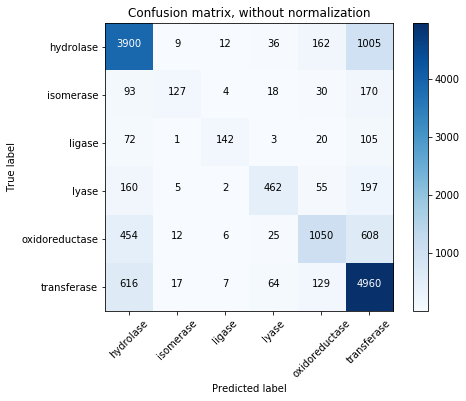

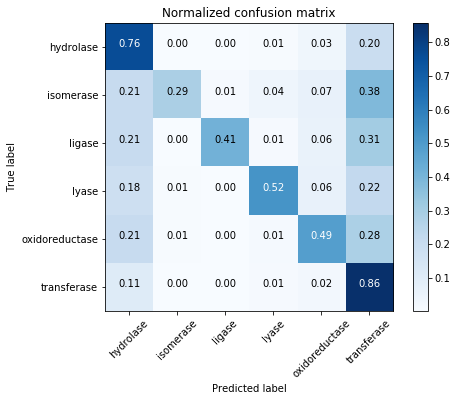

In [6]:
# Plot non-normalized confusion matrix
plt.figure(0, figsize=(7,7))
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure(1, figsize=(7,7))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()